# Data loading and pre-processing with TensorFlow

## Implementation

*Notebook written by the IDRIS AI support team, April 2021* 

This document describes the method to use on Jean Zay to load and pre-process input data for a distributed training. It illustrates the [IDRIS documentation](http://www.idris.fr/eng/jean-zay/gpu/jean-zay-gpu-tf-data-preprocessing-eng.html) and uses the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as reference. 

This Notebook contains: 
  * [Complete example](#exemple) of optimised loading 
  * [Comparison tests](#tests) of performance gains offered by each functionality described in the documentation (sharding, multithreading, prefetching, etc) 
  * Example of creation and usage of [TFRecord formats](#tfrecord)
 


### Computing environment

This notebook can be executed on any Jean Zay node but we advise using the jupyterhub front-end node (i.e. an *interactive* connection) to avoid consuming your allocation. In this case, the hostname is `jean-zay-srv2`:

In [1]:
!hostname

jean-zay-srv2


You need to load a TensorFlow module or choose a tensorflow kernel in the list at the upper-right corner of the notebook. The jobs will be submitted via Slurm in the `tensorflow-gpu/py3/2.4.1` environment.

In [2]:
import glob
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

### Places365 Images Dataset

In this notebook, we use the Places365 dataset present in the **$DSDIR** storage space.

These are images classified by theme (one directory per theme). We are taking the *data_large* version in order to maximize the data loading work, during our comparative tests.  
The dataset contains 1 803 460 images.

In [3]:
!tree -d -L 2 $DSDIR/Places365-Standard/

/gpfsdswork/dataset/Places365-Standard/
├── data_256
│   ├── a
│   ├── b
│   ├── c
│   ├── d
│   ├── e
│   ├── f
│   ├── g
│   ├── h
│   ├── i
│   ├── j
│   ├── k
│   ├── l
│   ├── m
│   ├── n
│   ├── o
│   ├── p
│   ├── r
│   ├── s
│   ├── t
│   ├── u
│   ├── v
│   ├── w
│   ├── y
│   └── z
├── data_large
│   ├── a
│   ├── b
│   ├── c
│   ├── d
│   ├── e
│   ├── f
│   ├── g
│   ├── h
│   ├── i
│   ├── j
│   ├── k
│   ├── l
│   ├── m
│   ├── n
│   ├── o
│   ├── p
│   ├── r
│   ├── s
│   ├── t
│   ├── u
│   ├── v
│   ├── w
│   ├── y
│   └── z
├── places365_standard
│   ├── train
│   └── val
├── test_256
├── test_large
├── train_image_lmdb
├── val_256
├── val_image_lmdb
└── val_large

59 directories


In [4]:
len(glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/**/*.jpg", recursive=True))

1803460

In order to reduce the testing time and be able to use the RAM cache function (without OOM error), we will only use the first 3 
classes, beginning by "air". This represents **15 000 images for 3 classes**.

In [6]:
!tree -dsh $DSDIR/Places365-Standard/data_large/a

/gpfsdswork/dataset/Places365-Standard/data_large/a
├── [ 256K]  airfield
├── [ 256K]  airplane_cabin
├── [ 256K]  airport_terminal
├── [ 256K]  alcove
├── [ 256K]  alley
├── [ 256K]  amphitheater
├── [ 256K]  amusement_arcade
├── [ 256K]  amusement_park
├── [ 4.0K]  apartment_building
│   └── [ 256K]  outdoor
├── [ 256K]  aquarium
├── [ 256K]  aqueduct
├── [ 256K]  arcade
├── [ 256K]  arch
├── [ 256K]  archaelogical_excavation
├── [ 256K]  archive
├── [ 4.0K]  arena
│   ├── [ 256K]  hockey
│   ├── [ 256K]  performance
│   └── [ 256K]  rodeo
├── [ 256K]  army_base
├── [ 256K]  art_gallery
├── [ 256K]  artists_loft
├── [ 256K]  art_school
├── [ 256K]  art_studio
├── [ 256K]  assembly_line
├── [ 4.0K]  athletic_field
│   └── [ 256K]  outdoor
├── [ 4.0K]  atrium
│   └── [ 256K]  public
├── [ 256K]  attic
├── [ 256K]  auditorium
├── [ 256K]  auto_factory
└── [ 256K]  auto_showroom

34 directories


In [7]:
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
random.Random(123).shuffle(places365_path)
len(places365_path)

15000

__Comment__:  The dataset structure is not flat. Some directories have multiple levels. Therefore, it is necessary to use a recursive glob. This requires using
a tf.data.Dataset.from_tensor_slices afterwards, rather than a tf.data.Dataset.list_files. Since the images are classified in alphabetical order, it is then necessary to do a shuffle on the path list. When using the shard distribution, the shuffle should be done with a seed.

### Exploration of the dataset

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(places365_path)

In [10]:
%time len(dataset)

CPU times: user 20 µs, sys: 687 µs, total: 707 µs
Wall time: 397 µs


15000

In [12]:
def decode_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    # decode jpeg format (channel=3 for RGB, channel=0 for Grayscale)
    img = tf.image.decode_jpeg(img, channels=3)
    # convert to [0,1] format for TensorFlow compatibility
    img = tf.image.convert_image_dtype(img, tf.float32)
    return label, img


In [13]:
dataset = dataset.shuffle(5000).map(decode_img, num_parallel_calls=1)

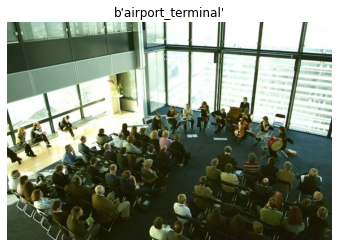

In [14]:
label, image = next(iter(dataset))
plt.imshow(image)
plt.axis('off')
plt.title(label.numpy())
plt.show()

In [15]:
%time len(dataset)

CPU times: user 336 µs, sys: 110 µs, total: 446 µs
Wall time: 293 µs


15000

In [17]:
dataset = dataset.batch(32, drop_remainder=True)

In [18]:
%time len(dataset)

CPU times: user 128 µs, sys: 42 µs, total: 170 µs
Wall time: 135 µs


468

In [20]:
dataset = dataset.repeat(3)

In [21]:
%time len(dataset)

CPU times: user 105 µs, sys: 35 µs, total: 140 µs
Wall time: 102 µs


1404

## Complete example of optimised loading <a class="anchor" id="exemple"></a>

### Creation of the dataloading Python script - optimised version

In [23]:
%%writefile places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    # decode jpeg format (channel=3 for RGB, channel=0 for Grayscale)
    img = tf.image.decode_jpeg(img, channels=3)
    # convert to [0,1] format for TensorFlow compatibility
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize image
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    # standardize image
    img = tf.image.per_image_standardization(img)
    return label, img


# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')

def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
sharding = True
caching = True
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        caching={caching}, prefetch_factor={prefetch_factor}')
    print(f'------')


# locate Places365 dataset in DSDIR and list places beginning with air
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
random.Random(123).shuffle(places365_path)

# create a dataset object from path
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')

if sharding:
    # get number of processes/workers
    num_workers = idr_tf.size
    worker_index = idr_tf.rank

    # distribute dataset
    dataset = dataset.shard(num_workers,worker_index)
    
    if idr_tf.rank == 0: print(f'Sharded Dataset length = {len(dataset)}')

# shuffling
dataset = dataset.shuffle(shuffling_buffer_size)

# deterministic transformation
dataset = dataset.map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)

if caching:
    dataset = dataset.cache()

# random transformations
dataset = dataset.map(randomized_preprocessing, num_parallel_calls=num_parallel_calls, deterministic=False)
    
# batching
dataset = dataset.batch(batch_size, drop_remainder=True)

# pre-load batches during training
if prefetch_factor:
    dataset = dataset.prefetch(prefetch_factor)

start_time = time.time()

## Repeat a num_epochs times
#dataset = dataset.repeat(num_epochs)
#for label, img in dataset:
#    a = 1 # emulate some action   
## equivalent to:
    
for epoch in range(num_epochs):
    for label, img in dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Overwriting places_loader.py


### Creation of the Slurm submission script

**Reminder**: If your single project has both CPU and GPU hours, or if your login is attached to multiple projects, you must specify for which allocation the consumed hours
 should be counted by adding the option `--account=my_project@gpu` as explained in the [IDRIS documentation](http://www.idris.fr/jean-zay/cpu/jean-zay-cpu-doc_account.html).

In [24]:
%%writefile job.slurm
#!/bin/bash
#SBATCH --job-name=data_loader_tensorflow-eng
##SBATCH --account=XXX@v100
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=4
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10
#SBATCH --hint=nomultithread
#SBATCH --exclusive
#SBATCH --time=00:30:00
#SBATCH --output=data_loader_tensorflow.out
#SBATCH --error=data_loader_tensorflow.err

module load tensorflow-gpu/py3/2.4.1

srun python -u places_loader.py

Overwriting job.slurm


### Submission and execution of the optimised version

In [25]:
import time
from IPython.display import clear_output
def display_slurm_queue():
    sq = !squeue -u $USER -n data_loader_tensorflow-eng
    while len(sq) >= 2:
        clear_output(wait=True)
        for l in sq: print(l)
        time.sleep(10)
        sq = !squeue -u $USER -n data_loader_tensorflow-eng
    print('\n Done!')

In [26]:
# submit job
!sbatch job.slurm

Submitted batch job 943701


In [27]:
# should take about 1 min
display_slurm_queue()


 Done!


In [28]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        caching=True, prefetch_factor=-1
------
Dataset length = 15000
Sharded Dataset length = 3750
Execution took 19.081642627716064 s


## Tests of the different optimisations <a class="anchor" id="tests"></a>

We wish here to observe the impact of the different parameters presented in the documentation on the data pre-processing performance. The parameters of interest in the tests below are:
   * Multithreading (num_parallel_calls) 
   * Batch size 
   * Distribution (shard) 
   * Exploitation of cache memory 
   * Prefetching of batches on the GPUs 

It should be noted that these tests are run on a small-sized database. This choice was made for educational purposes for the rapid comparison of execution and performance. The idea here is to be convinced of the benefits of each optimisation. The performance gain will potentially be much greater on a larger database. Note that using the RAM cache may not be possible with a larger database. 

----

 * Creation of directories to store
    * Slurm submission scripts
    * Python data loading scripts
    * Standard outputs of executions

In [29]:
!mkdir slurm
!mkdir scripts
!mkdir logs

mkdir: cannot create directory ‘slurm’: File exists
mkdir: cannot create directory ‘scripts’: File exists
mkdir: cannot create directory ‘logs’: File exists


* Preliminary Python and Slurm script creation with variable parameters

In [30]:
def create_new_scripts(batch_size=64, num_workers=1, num_parallel_calls=1, sharding=False,
                       caching=False, prefetch_factor=0):
    
    extension = f'{batch_size}_{num_workers}_{num_parallel_calls}_{sharding}_{caching}_{prefetch_factor}'
    slurm_fname=f'slurm/job_{extension}.slurm'
    script_fname=f'scripts/mnist_loader_{extension}.py'
    
    if num_workers <= 4: # mono node
        nnodes = 1
        ntasks_per_node = num_workers
    else: # multi node
        
        if num_workers % 4 != 0:
            print("-- Multi node config: num_workers must be divisible by 4")
            
        nnodes = int(num_workers / 4)
        ntasks_per_node = 4
          
    # create slurm submission script with new number of gpus
    ref_file = open("job.slurm","r")
    new_file = open(slurm_fname,"w")
    for line in ref_file:
        if line.strip().startswith('#SBATCH --nodes='):
            line = f'#SBATCH --nodes={nnodes}\n'        
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --ntasks-per-node='):
            line = f'#SBATCH --ntasks-per-node={ntasks_per_node}\n'        
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --gres=gpu:'):
            line = f'#SBATCH --gres=gpu:{ntasks_per_node}\n'
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --output='):
            line = f'#SBATCH --output=logs/data_loader_{extension}.out\n'
            new_file.write(line)
        elif line.strip().startswith('#SBATCH --error='):
            line = f'#SBATCH --error=logs/data_loader_{extension}.err\n'
            new_file.write(line)
        elif line.strip().startswith('srun'):
            line = f'srun python -u ' + script_fname
            new_file.write(line)
        else:
            new_file.write(line)
            
    # create python script with new parameters
    ref_file = open("places_loader.py","r")
    new_file = open(script_fname,"w")
    for line in ref_file:
        if line.strip().startswith('batch_size = '):
            line = f'batch_size = {batch_size}\n'
            new_file.write(line)
        elif line.strip().startswith('num_parallel_calls = '):
            line = f'num_parallel_calls = {num_parallel_calls}\n'
            new_file.write(line)
        elif line.strip().startswith('sharding = '):
            line = f'sharding = {sharding}\n'
            new_file.write(line)
        elif line.strip().startswith('caching = '):
            line = f'caching = {caching}\n'
            new_file.write(line)
        elif line.strip().startswith('prefetch_factor = '):
            line = f'prefetch_factor = {prefetch_factor}\n'
            new_file.write(line)
        else:
            new_file.write(line)
          
    return slurm_fname

### Reference results -- under-optimised version

The reference results correspond to an under-optimised version of the following parameters:
* Deactivated multithreading (num_parallel_calls=1) 
* Batch size = 64
* Number of workers = 1 
* No sharding 
* No caching
* No prefetching

In [31]:
# create and execute reference scripts
slurm_fname = create_new_scripts()
print(slurm_fname)
!sbatch $slurm_fname

slurm/job_64_1_1_False_False_0.slurm
Submitted batch job 943719


In [32]:
# should take about 6 min
display_slurm_queue()


 Done!


In [33]:
!cat logs/data_loader_64_1_1_False_False_0.out

 --- Running on 1 workers / 1 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=1,
        shuffling_buffer_size=5000, num_workers=1,
        caching=False, prefetch_factor=0
------
Dataset length = 15000
Execution took 265.14274191856384 s


### Multithreading - Number of parallel calls

* Estimate of time gain when increasing the number of parallel calls

In [34]:
# create and execute scripts with increasing number of num_parallel_calls
for num_parallel_calls in [2, 8, 10, 16]:
    slurm_fname = create_new_scripts(num_parallel_calls=num_parallel_calls)
    !sbatch $slurm_fname

Submitted batch job 943815
Submitted batch job 943820
Submitted batch job 943824
Submitted batch job 943826


In [35]:
display_slurm_queue()


 Done!


In [36]:
%%bash
for n in 1 2 8 10 16
do
    echo ">>> num_parallel_calls = $n" 
    grep "Execution took" logs/data_loader_64_1_${n}_False_False_0.out
done

>>> num_parallel_calls = 1
Execution took 265.14274191856384 s
>>> num_parallel_calls = 2
Execution took 151.8925337791443 s
>>> num_parallel_calls = 8
Execution took 157.31752395629883 s
>>> num_parallel_calls = 10
Execution took 169.4540252685547 s
>>> num_parallel_calls = 16
Execution took 320.8844213485718 s


__Comment__: The optimum number of parallel calls depends on the input size and the batch size. tf.data.AUTOTUNE enables automating this optimisation. 

### Batch size

* Estimate of time gain when batch size is increased

In [37]:
# create and execute scripts with increasing batch size (batch_size=8 already done in ref job)
for batch_size in [16, 32, 128, 256]:
    slurm_fname = create_new_scripts(batch_size=batch_size)
    !sbatch $slurm_fname

Submitted batch job 943928
Submitted batch job 943931
Submitted batch job 943934
Submitted batch job 943936


In [38]:
display_slurm_queue()


 Done!


In [39]:
%%bash
for size in 16 32 64 128 256
do
    echo ">>> batch_size = $size" 
    grep "Execution took" logs/data_loader_${size}_1_1_False_False_0.out
done

>>> batch_size = 16
Execution took 325.750940322876 s
>>> batch_size = 32
Execution took 398.1411192417145 s
>>> batch_size = 64
Execution took 265.14274191856384 s
>>> batch_size = 128
Execution took 264.7799460887909 s
>>> batch_size = 256
Execution took 402.2380518913269 s


### Number of workers - with sharding

* Estimate of time gain when the number of shared workers is increased

In [40]:
# create and execute scripts with increasing number of workers (num_workers=1 already done in ref job)
for num_workers in [1,2,4,8,16]:
    slurm_fname = create_new_scripts(num_workers=num_workers, sharding=True)
    !sbatch $slurm_fname

Submitted batch job 944870
Submitted batch job 944871
Submitted batch job 944872
Submitted batch job 944873
Submitted batch job 944880


In [41]:
display_slurm_queue()


 Done!


In [42]:
%%bash
for n in 1 2 4 8 16
do
    echo ">>> num_workers = $n" 
    grep "Execution took" logs/data_loader_64_${n}_1_True_False_0.out
done

>>> num_workers = 1
Execution took 540.8707537651062 s
>>> num_workers = 2
Execution took 270.791392326355 s
>>> num_workers = 4
Execution took 67.50346326828003 s
>>> num_workers = 8
Execution took 57.4291877746582 s
>>> num_workers = 16
Execution took 32.1276319026947 s


### Caching

* Estimate of time gain when using the RAM cache

In [43]:
slurm_fname = create_new_scripts(caching=True)
!sbatch $slurm_fname

Submitted batch job 944641


In [44]:
display_slurm_queue()


 Done!


In [45]:
%%bash
echo ">>> caching = False" 
grep "Execution took" logs/data_loader_64_1_1_False_False_0.out
echo ">>> caching = True" 
grep "Execution took" logs/data_loader_64_1_1_False_True_0.out

>>> caching = False
Execution took 265.14274191856384 s
>>> caching = True
Execution took 224.97079205513 s


### Prefetching

* Estimate of time gain when using prefetching and increasing the buffer size

In [46]:
for prefetch_factor in [2, 5, 10]:
    slurm_fname = create_new_scripts(prefetch_factor=prefetch_factor)
    !sbatch $slurm_fname

Submitted batch job 944676
Submitted batch job 944677
Submitted batch job 944678


In [47]:
display_slurm_queue()


 Done!


In [48]:
%%bash
for n in 0 2 5 10
do
    echo ">>> prefetch_factor = $n" 
    grep "Execution took" logs/data_loader_64_1_1_False_False_${n}.out
done

>>> prefetch_factor = 0
Execution took 265.14274191856384 s
>>> prefetch_factor = 2
Execution took 380.97881269454956 s
>>> prefetch_factor = 5
Execution took 294.73858857154846 s
>>> prefetch_factor = 10
Execution took 314.7612655162811 s


__Comment__:  In the test presented here, nothing is occurring in the GPUs so the prefetch has no interest. However, in a learning which intensively solicites the GPUs, the prefetch is strongly advised. The optimum number of parallel calls depends on the congestion between CPUs and GPUs. tf.data.AUTOTUNE enables automating this optimisation.

## TFRecord format <a class="anchor" id="tfrecord"></a>

The TFRecord format is optimised for a time gain in read. It is good practice to use these. 

### Dataset in only one TFRecord format

When all the dataset is centralised in only one TFrecord.

The personal user file in TFRecord format is stored in the user's personal **SCRATCH** space.

#### Creation and writing of TFRecord

In [49]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [50]:
# Create a dictionary with features that may be relevant.
def image_example(label, image_string):
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {
          'height': _int64_feature(image_shape[0]),
          'width': _int64_feature(image_shape[1]),
          'depth': _int64_feature(image_shape[2]),
          'label': _bytes_feature(label),
          'image_raw': _bytes_feature(image_string ),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)) 

In [51]:
def parse_img(file_path):
    # parse label
    label = tf.strings.split(file_path, sep='/')[-2]
    # read input file
    img = tf.io.read_file(file_path)
    
    return label, img

In [52]:
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
dataset = dataset.map(parse_img, num_parallel_calls=1)

In [53]:
record_file = os.environ['SCRATCH']+'/places365.tfrecords'

In [54]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.

with tf.io.TFRecordWriter(record_file) as writer:
    for label, image in tqdm(iter(dataset)):
        tf_example = image_example(label, image)
        writer.write(tf_example.SerializeToString())


15000it [01:24, 176.93it/s]


#### Reading and loading the TFRecord

In [55]:
tfr_dataset = tf.data.TFRecordDataset(record_file)

In [56]:
for raw_record in tfr_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 512
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\002\000\003\002\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#

In [57]:
def tf_parse(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    image, label = example['image_raw'][0], example['label'][0]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return label, image

In [58]:
tfr_dataset = tfr_dataset.shuffle(5000).map(tf_parse, num_parallel_calls=1)

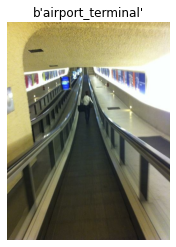

In [59]:
label, image = next(iter(tfr_dataset))
plt.imshow(image)
plt.axis('off')
plt.title(label.numpy())
plt.show()

__Comment__:  The dataset loaded from the TF Record does not know its size. The information is found in the source database which enabled the TFRecord creation. 


In [60]:
# Uncomment this line will cause an error
#len(tfr_dataset)

In [61]:
len(dataset)

15000

### Creation of the python dataloading script - optimised version 

In [63]:
%%writefile tfr_places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    img, label = example['image_raw'][0], example['label'][0]
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img = tf.image.per_image_standardization(img)
    return label, img

# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')
def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        prefetch_factor={prefetch_factor}')
    print(f'------')


# Search the length of dataset
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')

    
# Load the unique TFRecord Dataset
record_file = os.environ['SCRATCH']+'/places365.tfrecords'
tfr_dataset = tf.data.TFRecordDataset(record_file)
num_workers = idr_tf.size
worker_index = idr_tf.rank
tfr_dataset = (tfr_dataset.shard(num_workers,worker_index)
                          .shuffle(shuffling_buffer_size)
                          .map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)
                          .cache()
                          .map(randomized_preprocessing, num_parallel_calls=num_parallel_calls,deterministic=False)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(prefetch_factor)              
              )
              
start_time = time.time()
    
for epoch in range(num_epochs):
    for label, img in tfr_dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Writing tfr_places_loader.py


### Creation of the Slurm submission script

**Reminder**:  If your single project has CPU and GPU hours, or if your login is attached to multiple projects, you must specify from which attribution the hours consumed by your computations should be deducted by adding the option `--account=my_project@gpu`, as explained in the [IDRIS documentation](http://www.idris.fr/eng/jean-zay/cpu/jean-zay-cpu-doc_account-eng.html).

In [64]:
%%writefile job.slurm
#!/bin/bash
#SBATCH --job-name=data_loader_tensorflow-eng
##SBATCH --account=XXX@v100
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=4
#SBATCH --gres=gpu:4
#SBATCH --cpus-per-task=10
#SBATCH --hint=nomultithread
#SBATCH --exclusive
#SBATCH --time=00:30:00
#SBATCH --output=data_loader_tensorflow.out
#SBATCH --error=data_loader_tensorflow.err

module load tensorflow-gpu/py3/2.4.1

srun python -u tfr_places_loader.py

Overwriting job.slurm


In [65]:
# submit job
!sbatch job.slurm

Submitted batch job 944810


In [66]:
# should take about 30 sec
display_slurm_queue()


 Done!


In [67]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        prefetch_factor=-1
------
Dataset length = 15000
Execution took 18.553792715072632 s


### Dataset in shared TFRecord format

**For large databases**, it is preferable to segment the dataset into multiple TFrecord files. In addition, this is advised when using **sharding** as it allows each worker to read only a part of the TFRecord files.

#### Creation and writing of the shared TFRecord

**It is important that each part has the same number of samples** when using sharding in order to have the same number of batches in each process.

In the code below, we are dividing it into 8 parts. For large datasets, it is preferable to divide them into higher numbers (128, 256, 512, … parts)

In [68]:
part_places365_path= np.array(places365_path).reshape(8,-1)
part_places365_path.shape

(8, 1875)

In [70]:
part_dataset = [tf.data.Dataset.from_tensor_slices(part_places365_path[i]).map(parse_img, num_parallel_calls=1)
                for i in range(len(part_places365_path))]

In [71]:
part_record_file = [os.environ['SCRATCH']+f'/places365_{i}.tfrecords' for i in range(len(part_dataset))]

# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.

for i in range(len(part_dataset)):
    with tf.io.TFRecordWriter(part_record_file[i]) as writer:
        for label, image in tqdm(iter(part_dataset[i])):
            tf_example = image_example(label, image)
            writer.write(tf_example.SerializeToString())


1875it [00:05, 361.76it/s]
1875it [00:05, 360.73it/s]
1875it [00:09, 206.77it/s]
1875it [00:10, 172.00it/s]
1875it [00:10, 176.97it/s]
1875it [00:10, 177.15it/s]
1875it [00:10, 175.31it/s]
1875it [00:10, 172.16it/s]


In [72]:
glob.glob(os.environ['SCRATCH']+'/places365_*.tfrecords')

['/gpfsscratch/idris/sos/ssos938/places365_4.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_2.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_7.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_0.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_3.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_5.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_1.tfrecords',
 '/gpfsscratch/idris/sos/ssos938/places365_6.tfrecords']

#### Reading and loading the TFRecords

### Creation of the dataloading python script - optimised version 

In [74]:
%%writefile tfr_places_loader.py 
import tensorflow as tf
import idr_tf # IDRIS package available in all TensorFlow modules
import os
import glob
import random
import time

devices = tf.config.experimental.list_physical_devices("GPU")
nb_devices = len(devices)
if idr_tf.rank == 0:
    print(f' --- Running on {idr_tf.size} workers / {nb_devices} GPU ---')

IMG_WIDTH=320
IMG_HEIGHT=320
def decode_img(eg):
    example = tf.io.parse_example(
          eg[tf.newaxis], {
              'height': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'width': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'depth': tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
              'label': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
              'image_raw': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
          })
    img, label = example['image_raw'][0], example['label'][0]
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img = tf.image.per_image_standardization(img)
    return label, img

# Create a random generator
rng = tf.random.Generator.from_seed(123, alg='philox')
def randomized_preprocessing(label, img):
    # randomly adjust image contrast - Data Augmentation
    contrast_factor = random.random() + 1.0
    img = tf.image.adjust_contrast(img,contrast_factor=contrast_factor)
    img = tf.image.stateless_random_flip_left_right(img,rng.make_seeds(2)[0])
    return label, img

# configuration
num_epochs = 3
batch_size = 64
shuffling_buffer_size = 5000
num_parallel_calls = tf.data.AUTOTUNE
prefetch_factor = tf.data.AUTOTUNE

if idr_tf.rank == 0:
    print(f'------')
    print(f'Config: num_epochs={num_epochs}, batch_size={batch_size}, num_parallel_calls={num_parallel_calls},') 
    print(f'        shuffling_buffer_size={shuffling_buffer_size}, num_workers={idr_tf.size},')
    print(f'        prefetch_factor={prefetch_factor}')
    print(f'------')


# Search the length of dataset
places365_path = glob.glob(os.environ['DSDIR']+"/Places365-Standard/data_large/a/air*/**/*.jpg", recursive=True)
dataset = tf.data.Dataset.from_tensor_slices(places365_path)
if idr_tf.rank == 0:
    print(f'Dataset length = {len(dataset)}')
    
# Load the unique TFRecord Dataset

tfr_dataset = tf.data.Dataset.list_files(os.environ['SCRATCH']+'/places365_*.tfrecords')
num_workers = idr_tf.size
worker_index = idr_tf.rank
tfr_dataset = (tfr_dataset.shard(num_workers,worker_index)
                          .shuffle(shuffling_buffer_size)
                          .interleave(tf.data.TFRecordDataset, cycle_length=idr_tf.cpus_per_task, block_length=1)
                          .map(decode_img, num_parallel_calls=num_parallel_calls, deterministic=False)
                          .cache()
                          .map(randomized_preprocessing, num_parallel_calls=num_parallel_calls,deterministic=False)
                          .batch(batch_size, drop_remainder=True)
                          .prefetch(prefetch_factor)
              )
               
start_time = time.time()
    
for epoch in range(num_epochs):
    for label, img in tfr_dataset:
        a = 1 # emulate some action
        
        
end_time = time.time()
if idr_tf.rank == 0:
    print(f'Execution took {end_time - start_time} s')

Overwriting tfr_places_loader.py


In [75]:
# submit job
!sbatch job.slurm

Submitted batch job 944850


In [76]:
# should take about 30 sec
display_slurm_queue()


 Done!


In [77]:
# display output
!cat data_loader_tensorflow.out

 --- Running on 4 workers / 4 GPU ---
------
Config: num_epochs=3, batch_size=64, num_parallel_calls=-1,
        shuffling_buffer_size=5000, num_workers=4,
        prefetch_factor=-1
------
Dataset length = 15000
Execution took 18.44744610786438 s
